# Exploratory Analysis of BSS State and Trends

This notebook will provide the initial exploration and orientation with the BSS, and outputs may feature in the report. 

Note, at the time of writing the latest record is 2020-04-12 23:59

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import getcwd, chdir

In [2]:
# work from the project root
if getcwd()[-9:] == 'notebooks':
    chdir("..")

In [83]:
# connect to sqlite database
DBPATH = "data/bike_db.db"
db = sqlite3.connect(DBPATH)

## Explore monthly journey volumes

In [4]:
# Select Monthly-aggregated journey data
query = """
    SELECT
        year
        ,month
        ,COUNT(*) AS journeys
    FROM
        journeys
    WHERE
        year >= 2012
    GROUP BY 1,2
    ORDER BY 1,2
"""

mth_df = pd.read_sql_query(query, db)

In [5]:
# Merge year and month col into a proper datetime index
mth_df = mth_df.set_index(pd.to_datetime(mth_df[['year','month']].assign(day=1)))

In [6]:
def journey_plot(df, title='journeys', ylab='journeys'):
    ax = df.journeys.plot(
        figsize=(10,5)
        ,title=title
        ,grid=True);
    ax.set_ylabel(ylab);
    ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]);

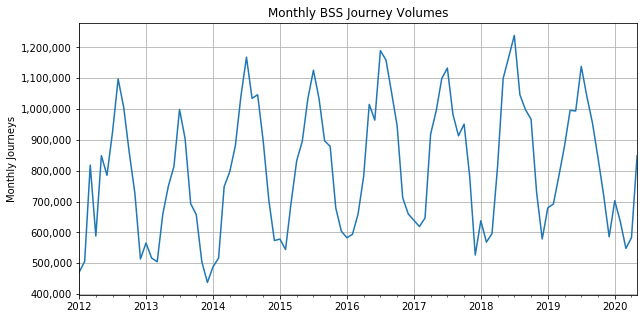

In [7]:
journey_plot(mth_df, 'Monthly BSS Journey Volumes', 'Monthly Journeys')

## Inspect 2020 at the daily level

In [8]:
# This fetches minute-ly data which we'll down-sample
df_20 = pd.read_sql_query("""
    SELECT
        "Start Date" AS start_date
        ,COUNT(*) AS journeys
    FROM
        journeys
    WHERE
        year = 2020
    GROUP BY 1
    """, db)

In [9]:
df_20['start_date'] = pd.to_datetime(df_20.start_date)
df_20.set_index('start_date', inplace=True)

I'm also fetching 2019 as a year-on-year comparison point

In [10]:
# This fetches minute-ly data which we'll down-sample
df_19 = pd.read_sql_query("""
    SELECT
        "Start Date" AS start_date
        ,COUNT(*) AS journeys
    FROM
        journeys
    WHERE
        year = 2019
        AND month <= 5
        AND "Start Date" <= "2019-05-26"
    GROUP BY 1
    """, db)

In [11]:
df_19['start_date'] = pd.to_datetime(df_19.start_date)
_ = df_19.copy()
df_19.set_index('start_date', inplace=True)

In [12]:
# My hacky way of overlaying 2019 with 2020
_['start_date'] = _['start_date'].apply(lambda x: x + pd.DateOffset(years=1))
_.set_index('start_date', inplace=True)

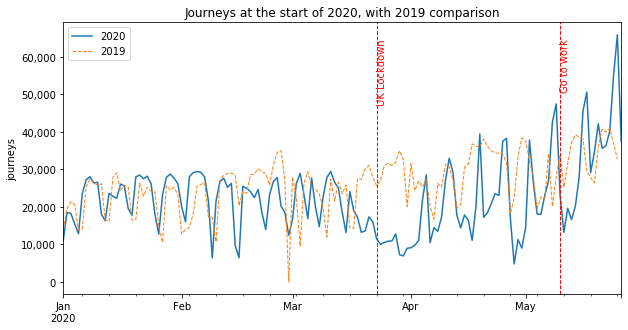

In [13]:
ax = df_20.resample('D').sum().plot(label='2020', figsize=(10,5)
                                   ,title='Journeys at the start of 2020, with 2019 comparison');
_.resample('D').sum().plot(ax = ax, label='2019', lw=1, linestyle='--');

ax.axvline(pd.to_datetime('2020-03-23'), color='r', linestyle='--', lw=1)
plt.text(pd.to_datetime('2020-03-23'),65000,'UK Lockdown',rotation=90, color='r', verticalalignment='top')

ax.axvline(pd.to_datetime('2020-05-10'), color='r', linestyle='--', lw=1)
plt.text(pd.to_datetime('2020-05-10'),65000,'Go to work',rotation=90, color='r', verticalalignment='top')

plt.legend(['2020','2019']);
ax.set_ylabel('journeys');
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]);
ax.set_xlabel(None);

In [14]:
del df_20
del df_19
del _

## Normal Daily Pattern

In [15]:
# This fetches minute-ly data which we'll down-sample
df_wkdy_hour = pd.read_sql_query("""
    SELECT
        weekday
        ,hour
        ,COUNT(*) AS journeys
    FROM
        journeys
    WHERE
        year = 2019
    GROUP BY 1,2
    """, db)

In [16]:
def plot_hourly_weekday(df, title, ax=None, figsize=(10,5)):
    df['weekday_ind'] = 'weekday'
    df.loc[df['weekday'].isin([5,6]), 'weekday_ind'] = 'weekend'
    
    ax = df.groupby(['weekday_ind','hour']).sum()['journeys'].unstack('weekday_ind') \
    .plot(figsize=figsize
          ,title=title
          ,grid=True
          ,ax=ax);
    ax.set_ylabel('journeys');
    ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]);
    return ax

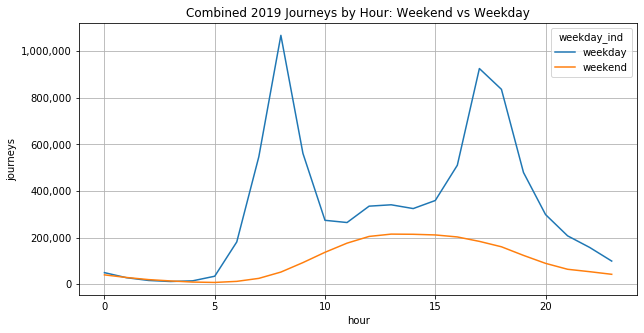

In [17]:
plot_hourly_weekday(df_wkdy_hour, title='Combined 2019 Journeys by Hour: Weekend vs Weekday');

In [18]:
del df_wkdy_hour

### Peek at the COVID-19 Pattern

In [20]:
# This fetches minute-ly data which we'll down-sample
df_wkdy_hour_covid = pd.read_sql_query("""
    SELECT
        weekday
        ,hour
        ,COUNT(*) AS journeys
    FROM
        journeys
    WHERE
        year = 2020
        AND month >= 3
        AND "Start Date" >= '2020-03-23'
    GROUP BY 1,2
    """, db)

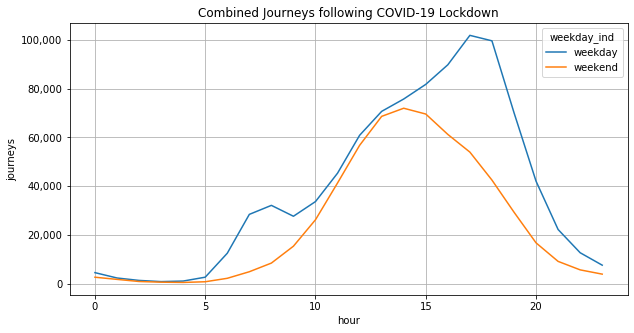

In [21]:
plot_hourly_weekday(df_wkdy_hour_covid, title='Combined Journeys following COVID-19 Lockdown');

In [22]:
del df_wkdy_hour_covid

### Evolution of 2020 by week
I will now plot one chart per week over 2020, so we can see how the usage pattern changed as the COVID-19 situation evolved. 

This isn't just interesting: it also informs us where to draw an appropriate cut-off for our time window

In [23]:
# This fetches minute-ly data which we'll down-sample
df_wkdy_hour_2020 = pd.read_sql_query("""
    SELECT
        strftime('%W', "Start Date") AS weekofyear
        ,weekday
        ,hour
        ,COUNT(*) AS journeys
    FROM
        journeys
    WHERE
        year = 2020
    GROUP BY 1,2,3
    """, db)

In [24]:
df_wkdy_hour_2020['weekofyear'] = df_wkdy_hour_2020['weekofyear'].astype(int)
df_wkdy_hour_2020['weekofyear'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

Note: ignoring week 22 as it is incomplete given data at present

Also note that week 0 is not a complete week, so weekdays have lower amplitude

In [25]:
nweeks = 21 # ignore 22
# for the subplots:
nrows = 7
ncols = 3
figsize=()

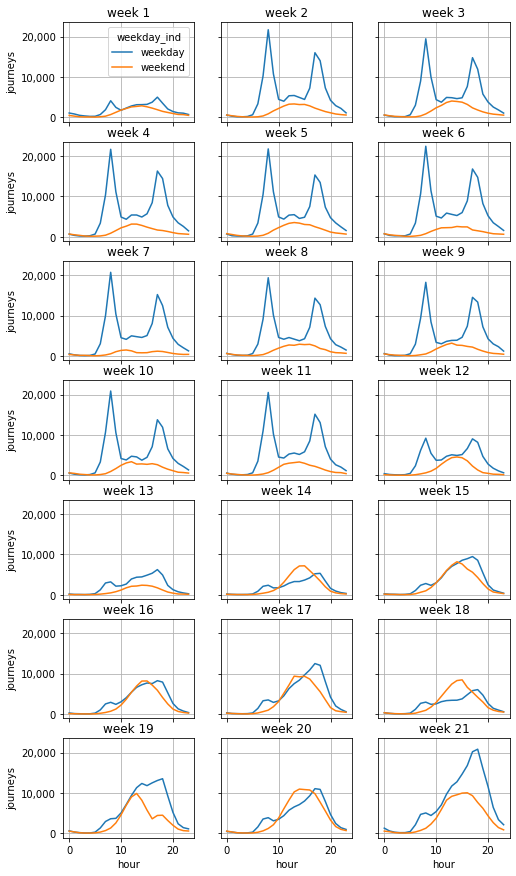

In [26]:
# Plot one weekofyear at a time

# I temporarily disable chained assignment warnings
pd.set_option('mode.chained_assignment', None)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(8,15))

for i in range(nweeks):
    plot_col = (i % ncols)
    plot_row = (i // ncols)
    plot_hourly_weekday(df_wkdy_hour_2020[df_wkdy_hour_2020['weekofyear'] == i]
                        ,title='week '+str(i+1)
                        ,ax=axes[plot_row][plot_col]
                        ,figsize=None
                       );
    if i != 0:  # remove legend in all but first figure
        axes[plot_row][plot_col].get_legend().remove()

pd.set_option('mode.chained_assignment', 'raise')

In [27]:
del df_wkdy_hour_2020

Noting that week 1 was not a complete week, we see that 2020 got off to a normal start. Then week 12 (16-22 of March) is when we see a clear reaction to COVID-19. The following week the UK lockdown came into force and the weekday traffic falls away completely. 

So I propose that usage patterns should be usable up to week ending 15/03/2020.

---
# Station Availability and System Load 
System-level EDA

In [28]:
# Manually excluding one timestamp where only three bikepoints were recorded?
station_fill = pd.read_sql_query("""
    SELECT
        timestamp, bikepoint_id, docked, empty, docked + empty AS capacity
    FROM
        station_fill
    WHERE
        timestamp != "2020-06-22 10:00:00"
    """, db, parse_dates=['timestamp'])

In [36]:
# we have data at the station level, but for now we'll look at the system in aggregate
system_fill = station_fill.groupby('timestamp').sum().drop('bikepoint_id', axis=1)

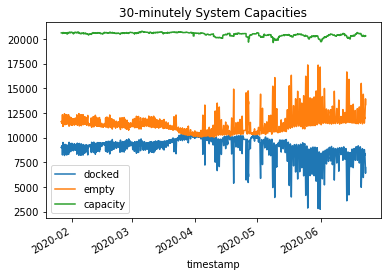

In [37]:
system_fill.plot(title='30-minutely System Capacities');

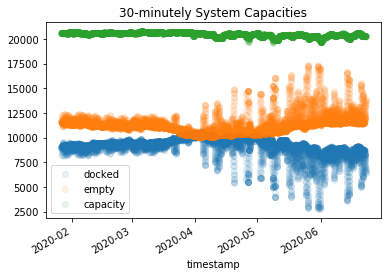

In [38]:
system_fill \
    .plot(marker='o'
          ,linestyle=''
          ,alpha=0.1
          ,title='30-minutely System Capacities'
         );

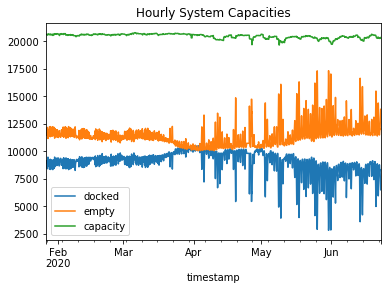

In [41]:
# average values per hour
system_fill \
    .resample('1H').mean() \
    .plot(title='Hourly System Capacities');

In [190]:
del station_fill

## Typical Daily Load-Factor 
At the system level, pre-covid.

**"Normalized bike availability" (NAB)** AKA **"load factor"** is the proporiton of docks with bikes in them at a point in time. NAB is lower at times when there are many rentals in progress. 

In [43]:
system_fill['nab'] = system_fill['docked'] / system_fill['capacity']

Let's see the typical daily load factor the system in aggregate, during **non COVID conditions**

In [51]:
system_fill_normal = system_fill.loc[:'2020-03-15']

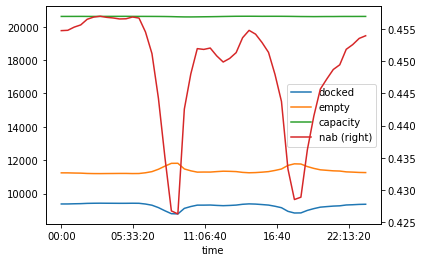

In [72]:
system_fill_normal.groupby(system_fill_normal.index.time).mean() \
    .plot(secondary_y = ('nab'));

In [189]:
del system_fill
del system_fill_normal

## Merge Journey and Station Data
Use the station fill data and merge it the journey data to capture a "bikes mid-journey" metric. 

In theory:
total bikes in system = docked bikes + bikes mid-journey

Apparently SQL is the right tool for the job, here

In [75]:
def table_exists(table):
    """Check if table exists already"""
    c = db.cursor()
    c.execute(f''' SELECT count(name) FROM sqlite_master WHERE type='table' AND name='{table}' ''')
    if c.fetchone()[0] == 1:
        c.close()
        return True
    else:
        c.close()
        return False

This statment took 11 minutes to execute, so I created a table so it only has to be done once.

I'm quite proud of the amount of optimisation I did here, so I'm going to do a little write-up about it: https://mscproject.myjetbrains.com/youtrack/articles?draft=142-1

In [88]:
if not table_exists('total_system_use'):
    c = db.cursor()
    statement = """
        CREATE TABLE total_system_use AS 
            SELECT
                s.timestamp
                ,s.docked
                ,s.empty
                ,COUNT("Rental Id") AS journeys_in_progress
            FROM
                (
                    SELECT
                        timestamp
                        ,strftime('%m', timestamp) AS month
                        ,weekday
                        ,strftime('%H', timestamp) AS hour
                        -- this helps in indexing more efficiently in the outer query
                        ,CASE 
                            WHEN hour > 1 THEN hour-2
                            ELSE 0 END AS start_range
                        ,CASE 
                            WHEN hour > 1 THEN hour
                            ELSE 24 END AS end_range
                        ,SUM(docked) AS docked
                        ,SUM(empty) AS empty
                    FROM station_fill
                    WHERE timestamp <= '2020-05-26'  --last journey in data at present
                    GROUP BY 1,2,3,4,5,6
                ) AS s
            LEFT JOIN journeys AS j
                ON j.year = 2020
                AND s.month = j.month
                AND s.weekday = j.weekday
                AND j.hour BETWEEN s.start_range AND s.end_range
                -- previous conditions are logically redundant, but they optimize the query by allowing use of an index
                AND s.timestamp BETWEEN j."Start Date" AND j."End Date"
            GROUP BY 1,2,3
;
    """
    c.execute(statement)
    c.close()

### Infer Total Bikes in System (at point in time)

In [89]:
total_system_use = pd.read_sql_query("""SELECT * FROM total_system_use"""
                                     , db, parse_dates=['timestamp'], index_col='timestamp')

In [91]:
total_system_use['bikes_in_system'] = total_system_use['docked'] + total_system_use['journeys_in_progress']

Add some columns for plotting convenience:

In [136]:
total_system_use['day_of_week'] = total_system_use.index.dayofweek
total_system_use['time'] = total_system_use.index.time
total_system_use['weekofyear'] = total_system_use.index.weekofyear

Plot some viz

In [138]:
normal_tsu = total_system_use.loc[:'2020-03-15']

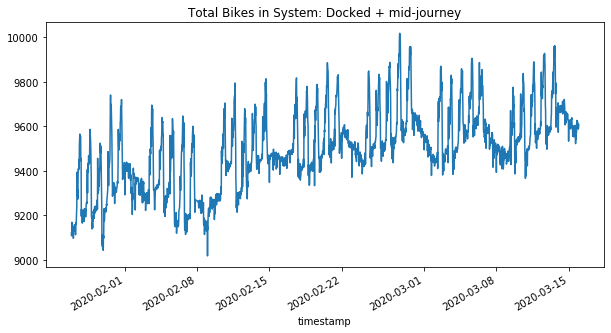

In [186]:
normal_tsu['bikes_in_system'] \
    .plot(title='Total Bikes in System: Docked + mid-journey',figsize=(10,5));

### Pivot into a weekly plot

In [166]:
week_piv = normal_tsu.pivot_table(index=['day_of_week', 'time'], columns='weekofyear', values='bikes_in_system')

In [175]:
week_piv_norm = (week_piv - week_piv.iloc[0]).drop(4, axis=1)

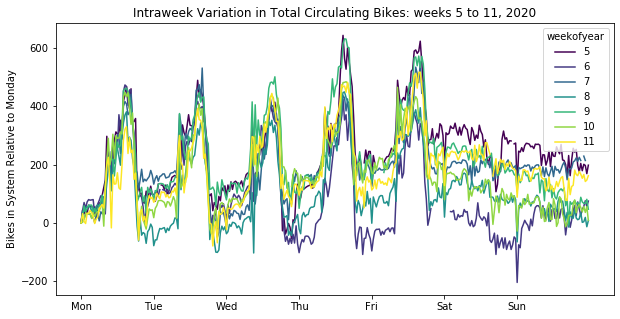

In [184]:
ax = week_piv_norm.plot(cmap='viridis' 
                   ,figsize=(10,5)
                  );
plt.xticks(
    [i*48 for i in range(7)]
    ,['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
);

ax.set_xlabel(None);
ax.set_ylabel('Bikes in System Relative to Monday');
ax.set_title('Intraweek Variation in Total Circulating Bikes: weeks 5 to 11, 2020');

In [191]:
del week_piv
del week_piv_norm
del total_system_use
del normal_tsu